<a href="https://colab.research.google.com/github/igmim-yassine/Pytorch-Tutorial/blob/master/04E_NMT_SEq2SeqModels%26Attention_NLP_class_Emines_Jan2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Summary: Build a Machine Translation Algorithm with Seq2Seq Model and Attention mechanism
In this notebook, you will learn: 
* Preprocess a french-english sentences dataset for machine translation
> Dataset available here: https://drive.google.com/drive/folders/1npjvI_9qFKuamCLwlG8fG9lzZZCrsowT?usp=sharing
* Build an sequence to sequence model with Bahdanau attention on the dataset
> This is the implementation of this paper: 
https://arxiv.org/pdf/1409.0473.pdf
* Train the Machine Translation algorithm 
* Translate French to English sentences using the trained Seq2Seq Model. 



In [ ]:
import tensorflow as tf
import re
import string
from pickle import dump
from unicodedata import normalize
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import collections

### Preparing the dataset
* unicode normalization: https://docs.python.org/3/library/unicodedata.html
* There is punctuation to remove.
* The text contains uppercase and lowercase.
* There are special characters => use `string.printable` to remove it.
* There are duplicate phrases in English with different translations in French.
* The file is ordered by sentence length with very long sentences toward the end of the file.

In [ ]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, mode='rt' , encoding='utf-8')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

In [ ]:
# split a loaded document into sentences
def to_pairs(doc):
  lines = doc.strip().split('\n') # split document by line
  pairs = [line.split('\t') for line in lines]
  return pairs

In [ ]:
# clean a list of lines
def clean_pairs_fn(lines):
  cleaned = list()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  for pair in lines:
    clean_pair = list()
    for line in pair:
      # normalize unicode characters
      line = normalize('NFD' , line).encode('ascii' , 'ignore')
      line = line.decode('UTF-8')
      # remove "-" in composed words "serre-toi", etc...
      line = line.replace("-", " ")
      # remove "'" in composed words "j'ai", etc...
      line = line.replace("'", " ")
      # tokenize on white space
      line = line.split()
      # convert to lowercase
      line = [word.lower() for word in line]
      # remove punctuation from each token
      line = [re_punc.sub('', w) for w in line]
      # remove non-printable chars form each token
      line = [re_print.sub('', w) for w in line]
      # remove tokens with numbers in them
      line = [word for word in line if word.isalpha()]
      # Add <SOS> + <EOS> token
      line = ["<SOS>"] + line + ["<EOS>"]
      # store as string
      clean_pair.append(' '.join(line))
    cleaned.append(clean_pair)
  return np.array(cleaned)

In [ ]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
  dump(sentences, open(filename, 'wb'))
  print('Saved: %s' % filename)

In [ ]:
filename = '/content/drive/MyDrive/12_Teaching/UM6P-NLP-Jan2022/notebooks/fra-eng/fra.txt'
doc = load_doc(filename)
# split into english-french pairs
pairs = to_pairs(doc)
print("number of pairs", len(pairs))
for i in range(50):
  print(pairs[i])

number of pairs 192341
['Go.', 'Va !', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)']
['Go.', 'Marche.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)']
['Go.', 'Bouge !', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)']
['Hi.', 'Salut !', 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)']
['Hi.', 'Salut.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)']
['Run!', 'Cours\u202f!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)']
['Run!', 'Courez\u202f!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)']
['Run!', 'Prenez vos jambes à vos cous !', 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077449 (sacredceltic)']
['Run!', 'File !', 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077454 (sacredceltic)

In [ ]:
# clean sentences
clean_pairs = clean_pairs_fn(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-french.pkl')
# spot check
for i in range(50):
  print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-french.pkl
[<SOS> go <EOS>] => [<SOS> va <EOS>]
[<SOS> go <EOS>] => [<SOS> marche <EOS>]
[<SOS> go <EOS>] => [<SOS> bouge <EOS>]
[<SOS> hi <EOS>] => [<SOS> salut <EOS>]
[<SOS> hi <EOS>] => [<SOS> salut <EOS>]
[<SOS> run <EOS>] => [<SOS> cours <EOS>]
[<SOS> run <EOS>] => [<SOS> courez <EOS>]
[<SOS> run <EOS>] => [<SOS> prenez vos jambes a vos cous <EOS>]
[<SOS> run <EOS>] => [<SOS> file <EOS>]
[<SOS> run <EOS>] => [<SOS> filez <EOS>]
[<SOS> run <EOS>] => [<SOS> cours <EOS>]
[<SOS> run <EOS>] => [<SOS> fuyez <EOS>]
[<SOS> run <EOS>] => [<SOS> fuyons <EOS>]
[<SOS> run <EOS>] => [<SOS> cours <EOS>]
[<SOS> run <EOS>] => [<SOS> courez <EOS>]
[<SOS> run <EOS>] => [<SOS> prenez vos jambes a vos cous <EOS>]
[<SOS> run <EOS>] => [<SOS> file <EOS>]
[<SOS> run <EOS>] => [<SOS> filez <EOS>]
[<SOS> run <EOS>] => [<SOS> cours <EOS>]
[<SOS> run <EOS>] => [<SOS> fuyez <EOS>]
[<SOS> run <EOS>] => [<SOS> fuyons <EOS>]
[<SOS> who <EOS>] => [<SOS> qui <EOS>]
[<SOS> wow <EOS>] => [<SOS> ca al

The clean data contains a little over 190,000 phrase pairs and some of the pairs toward the end
of the file are very long. This is a good number of examples for developing a small translation
model. The complexity of the model increases with the number of examples, length of phrases,
and size of the vocabulary. Although we have a good dataset for modeling translation, we will
simplify the problem slightly to dramatically reduce the size of the model required, and in turn
the training time required to fit the model.

You can explore developing a model on the fuller dataset as an extension; I would love to
hear how you do. We will simplify the problem by reducing the dataset to the first 50,000
examples in the file; these will be the shortest phrases in the dataset. Further, we will then
stake the first 40,000 of those as examples for training and the remaining 10,000 examples to test
the fit model.

In [ ]:
from pickle import load
from pickle import dump
from numpy.random import shuffle
# load a clean dataset
def load_clean_sentences(filename):
  return load(open(filename, 'rb'))
# load dataset
raw_dataset = load_clean_sentences('english-french.pkl')
# reduce dataset size
n_sentences = 50000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:40000], dataset[40000:]
# save
save_clean_data(dataset, 'english-french-both.pkl')
save_clean_data(train, 'english-french-train.pkl')
save_clean_data(test, 'english-french-test.pkl')

Saved: english-french-both.pkl
Saved: english-french-train.pkl
Saved: english-french-test.pkl


In [ ]:
# load datasets
dataset = load_clean_sentences('english-french-both.pkl')
train = load_clean_sentences('english-french-train.pkl')
test = load_clean_sentences('english-french-test.pkl')

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer() # create an tokenizer object
  tokenizer.fit_on_texts(lines) # Build the vocabulary
  return tokenizer

In [ ]:
# max sentence length - used for padding. 
def max_length(lines):
  return max(len(line.split()) for line in lines)

In [ ]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1 # for padding token.
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare french tokenizer
fr_tokenizer = create_tokenizer(dataset[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1 # for padding token. 
fr_length = max_length(dataset[:, 1])
print('French Vocabulary Size: %d ' % fr_vocab_size)
print('French Max Length: %d ' % (fr_length))

English Vocabulary Size: 5933
English Max Length: 9
French Vocabulary Size: 10313 
French Max Length: 17 


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  X = pad_sequences(X, maxlen=length, padding='post')
  return X

In [ ]:
# prepare training data
trainX = encode_sequences(fr_tokenizer, fr_length, train[:, 1])
print("train input shape", trainX.shape)
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
print("train target shape", trainY.shape)
# prepare validation data
testX = encode_sequences(fr_tokenizer, fr_length, test[:, 1])
print("test input shape", testX.shape)
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
print("test input shape", testY.shape)

train input shape (40000, 17)
train target shape (40000, 9)
test input shape (10000, 17)
test input shape (10000, 9)


In [ ]:
trainX[0]

array([  1,  82, 207,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [ ]:
BUFFER_SIZE = len(trainX)
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(BUFFER_SIZE) # tensorflow dataset. 
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testY)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

### The encoder

Start by building the encoder, the blue part of the diagram above.

The encoder:

1. Takes a list of token IDs.
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a `layers.GRU`).
5. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    # attributes
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(input_dim=self.input_vocab_size, output_dim=embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(units=self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens) # (batch, seq_len, embedding_dim)

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    

    # 4. Returns the new sequence and its state.
    return output, state

In [ ]:
# TEST THE ENCODER
embedding_dim = 32
units= 128
encoder = Encoder(fr_vocab_size,
                    embedding_dim, units)
for (input_tokens, target_tokens)  in train_dataset.take(1):
  # Encode the input sequence.
  example_enc_output, example_enc_state = encoder(input_tokens)

  print(f'Input batch tokens, shape (batch, s): {input_tokens.shape}')
  print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
  print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch tokens, shape (batch, s): (64, 17)
Encoder output, shape (batch, s, units): (64, 17, 128)
Encoder state, shape (batch, units): (64, 128)


### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_1.jpg?raw=1" alt="attention equation 1" width="800">

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_2.jpg?raw=1" alt="attention equation 2" width="800">

Where:
* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in general attention model terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in general attention model terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_4.jpg?raw=1" alt="attention equation 4" width="800">

This tutorial uses [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf).  
 TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`. The class below handles the weight matrices in a pair of `layers.Dense` layers, and calls the builtin implementation.  
See documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention



In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)
    # attention layer
    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query) # query = h_t of decoder
    # From Eqn. (4), `W2@hs`.
    w2_value = self.W2(value) # value = h_s of the encoder. 

    # compute masks
    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool) # shape (batch, query_sequence_length)
    value_mask = mask

    # compute attention vector using self.attention
    context_vector, attention_weights = self.attention(inputs=[w1_query, value, w2_value], mask=[query_mask, value_mask], return_attention_scores=True)

    return context_vector, attention_weights

In [ ]:
# TEST THE ATTENTION LAYER
attention_layer = BahdanauAttention(units)
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(input_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(input_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 128)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 17)


Text(0.5, 1.0, 'Mask')

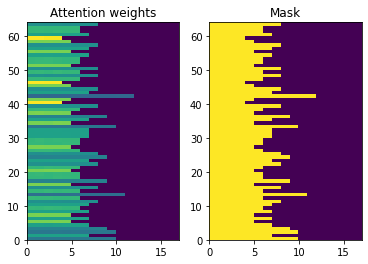

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(input_tokens != 0)
plt.title('Mask')

### The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_3.jpg?raw=1" alt="attention equation 3" width="800">

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

The decoder takas an input a Nested Input with three elements (new_tokens = target tokens being decoded, enc_output, mask = to mask the padding tokens from the encoder output)

In [ ]:
NestedInput = collections.namedtuple('NestedInput', ['new_tokens', 'enc_output', 'mask'])
#new_tokens = NestedInput.new_tokens
#enc_output = NestedInput.enc_output
#mask = NestedInput.mask

In [ ]:
def call(self,
         inputs,
         state=None):

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)


  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)


  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)

  return logits, attention_weights, state

In [ ]:
Decoder.call = call

The **encoder** processes its full input sequence with a single call to its RNN.

In [ ]:
eng_tokenizer.word_index["sos"]

1

In [ ]:
# Test the Decoder. 
decoder = Decoder(eng_vocab_size,
                  embedding_dim, units)

start_index = eng_tokenizer.word_index["sos"]
first_token = tf.constant([[start_index]] * target_tokens.shape[0])
# Run the decoder
logits, attn_weights, dec_state = decoder(
    inputs = NestedInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(input_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')
# Sample a token according the logits. 
sampled_token = tf.random.categorical(logits[:, 0, :], num_samples=1)

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5933)
state shape: (batch_size, dec_units) (64, 128)


## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred) # y_true (batch, s=9) y_pred (batch, s, output_vocab_size)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask # loss = loss * mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step
Start with a model class, the training process will be implemented as the `train_step` method on this model. See [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units, inp_vocab_size, tar_vocab_size,
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(inp_vocab_size,
                      embedding_dim, units)
    decoder = Decoder(tar_vocab_size,
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.use_tf_function = use_tf_function

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

In [ ]:
def _create_masks(self, input_tokens, target_tokens):
  # Convert IDs to masks.
  input_mask = input_tokens != 0
  target_mask = target_tokens != 0
  return input_mask, target_mask

In [ ]:
def _train_step(self, inputs):
  input_tokens, target_tokens = inputs  

  (input_mask, target_mask) = self._create_masks(input_tokens, target_tokens)

  max_target_length = target_tokens.shape[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:,t:t+2] # get y_t, y_{t+1}
      step_loss, dec_state = self._loop_step(new_tokens, input_mask, enc_output, dec_state)

      loss += step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables # get all weights of all layers of the tf.keras.Model
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

The _loop_step method, added below, executes the decoder and calculates the incremental loss and new decoder state (dec_state).

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2] # input token as a new_tokens input for the decoder, target_token is for the loss. 

  # Run the decoder one step.
  decoder_input = NestedInput(new_tokens=input_token, enc_output=enc_output, mask=input_mask)
  y_pred, _, dec_state = self.decoder(decoder_input, state=dec_state)

  # `self.loss` returns the total for non-padded tokens
  step_loss = self.loss(target_token, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._create_masks = _create_masks
TrainTranslator._train_step = _train_step
TrainTranslator._loop_step = _loop_step

### Test the training step
Build a `TrainTranslator`, and configure it for training using the `Model.compile` method:

In [ ]:
translator = TrainTranslator(
    embedding_dim, units, inp_vocab_size=fr_vocab_size, tar_vocab_size=eng_vocab_size,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

The loss should start around: 

In [ ]:
np.log(eng_vocab_size)

8.688285266258644

In [ ]:
%%time
for n in range(10):
  print(translator.train_step((input_tokens, target_tokens)))
print("done")

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.301533>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.298201>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2944903>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2899904>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.284255>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2767653>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2668867>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2538114>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.236515>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.213669>}
done
CPU times: user 6.28 s, sys: 444 ms, total: 6.73 s
Wall time: 5.74 s


While it's easier to debug without a tf.function it does give a performance boost. So now that the _train_step method is working, try the tf.function-wrapped _tf_train_step, to maximize performance while training:

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, input_tokens.shape[1]]),
                               tf.TensorSpec(dtype=tf.int32, shape=[None, target_tokens.shape[1]])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step
translator.use_tf_function = True

The first call will be slow, because it traces the function.

In [ ]:
translator.train_step([input_tokens, target_tokens])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.1835523>}

But after that it's usually 2-3x faster than the eager `train_step` method:

A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

....................................................................................................


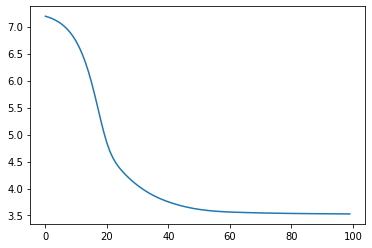

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([input_tokens, target_tokens])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [ ]:
embedding_dim = 128
units = 256
train_translator = TrainTranslator(
    embedding_dim, units, inp_vocab_size=fr_vocab_size, tar_vocab_size=eng_vocab_size,
    use_tf_function=False)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs): # method of tf.keras.callbacks.Callback
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(train_dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
625/625 [==============================] - 251s 367ms/step - batch_loss: 3.7594
Epoch 2/3
625/625 [==============================] - 258s 413ms/step - batch_loss: 2.6962
Epoch 3/3
625/625 [==============================] - 246s 394ms/step - batch_loss: 2.0234


Text(0, 0.5, 'CE/batch')

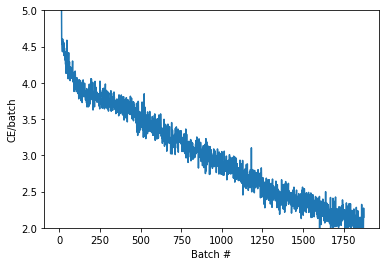

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([2, 5])
plt.xlabel('Batch #')
plt.ylabel('CE/batch')

### Translate
Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, output_id2word,
               output_word2id):
    self.encoder = encoder
    self.decoder = decoder
    self.output_id2word = output_id2word
    self.output_id2word[0] = "<pad>"
    self.output_word2id = output_word2id
    self.output_word2id["<pad>"] = 0

    token_mask_ids = [self.output_word2id[w] for w in ["sos", "<pad>"]]
    token_mask = np.zeros([len(self.output_id2word)], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = self.output_word2id["sos"]
    self.end_token = self.output_word2id["eos"]

  def output_token_string_from_index(self, token_ids):
    # tokens_ids (batch, seq_len)
    tokens_array = []
    for i in range(token_ids.shape[0]):
      tokens_array.append([self.output_id2word[index] for index in token_ids[i].numpy()])
    return tf.constant(tokens_array)

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    output_id2word=eng_tokenizer.index_word,
    output_word2id=eng_tokenizer.word_index)

NameError: ignored

### Convert token IDs to text
The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.  
This uses the `tf.strings` module: https://www.tensorflow.org/api_docs/python/tf/strings 

In [ ]:
def tokens_to_text(self, result_tokens):
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ') #" ".join(list)
  result_text = tf.strings.strip(result_text) # Strip leading and trailing whitespaces from the Tensor.
  return result_text # list of decoded sentences over the batch 

In [ ]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=len(eng_tokenizer.index_word)+1)
translator.tokens_to_text(example_output_tokens)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'unreasonable sweated', b'yell shizuoka', b'dozen toothache',
       b'practice gentlemen', b'undergrad blinds'], dtype=object)>

### Sample from the decoder's predictions
This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [ ]:
def sample(self, logits, temperature):
  # sample with temperature
  # if temperature = 0. => greedy decoding. 

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  # if temperature == 0:
      # greedy decoding: tf.math.argmax()
  # else: 
      # sampling with temperature: logits / temp + tf.random.categorical(logits/temp)


  return new_tokens

In [ ]:
Translator.sample = sample

Test run this function on some random inputs:

In [ ]:
example_logits = tf.random.normal([5, 1, eng_vocab_size]) # check which size of vocabulary to take. 
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4377],
       [ 565],
       [3744],
       [2912],
       [5852]])>

In [ ]:
def translate_unrolled(self,
                       input_tokens, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_tokens)[0]
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    # 1. create a NestedInput for the decoder

    # 2. Pass forward on the decoder to obtain logits, attention_weights, decoder_state:


    # sample new tokens using self.sample:


    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens

 
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings using self.token_to_text.
  

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    output_id2word=eng_tokenizer.index_word,
    output_word2id=eng_tokenizer.word_index)

In [ ]:
%%time
input_text = [
    'Il fait très froid ici .', # "It's really cold here."
    'C est ma vie .', # "This is my life.""
]
max_len = max([len(e.split(' ')) for e in input_text])
input_tokens = encode_sequences(tokenizer=fr_tokenizer, length=max_len, lines=input_text)

result = translator.translate(
     input_tokens = input_tokens)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

he is skinny <pad> <pad>
that s my problem <pad>

CPU times: user 133 ms, sys: 3.09 ms, total: 136 ms
Wall time: 134 ms
